In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import swiper.plot as plotter
from typing import Any

In [2]:
directory = 'slurm/data/sensitivity'

In [3]:
with open(f'{directory}/config.json', 'r') as f:
    config = json.load(f)

In [4]:
data_by_config = {}

for file in os.listdir(f'{directory}/output/'):
    print(file)
    with open(f'{directory}/output/{file}', 'r') as f:
        contents = f.read()
        if len(contents) == 0:
            print('Empty file!')
            continue
        data = json.loads(contents)
    config_idx = int(file.split('_')[0][6:])
    data_by_config[config_idx] = data

config177_d21_aligned_separate_random_t_1000_200_0_0.json
config92_d21_sliding_separate_random_t_1000_200_0_0.json
config228_d21_parallel_separate_random_t_1000_200_0_0.json
config162_d21_parallel_separate_random_t_1000_200_0_0.json
config152_d21_sliding_separate_random_t_1000_200_0_0.json
config5_d21_sliding_separate_random_t_1000_200_0_0.json
config237_d21_aligned_separate_random_t_1000_200_0_0.json
config38_d21_sliding_separate_random_t_1000_200_0_0.json
config252_d21_parallel_separate_random_t_1000_200_0_0.json
config60_d21_sliding_separate_random_t_1000_200_0_0.json
config13_d21_parallel_separate_random_t_1000_200_0_0.json
config212_d21_sliding_separate_random_t_1000_200_0_0.json
config156_d21_sliding_separate_random_t_1000_200_0_0.json
config1_d21_sliding_separate_random_t_1000_200_0_0.json
config173_d21_aligned_separate_random_t_1000_200_0_0.json
config299_d21_aligned_separate_random_t_1000_200_0_0.json
config96_d21_sliding_separate_random_t_1000_200_0_0.json
config64_d21_slidin

In [5]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    indices = []
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            indices.append(idx)
    if len(indices) == 1:
        return indices[0]
    else:
        print(f'Found {len(indices)} matches for {schedule_name} and {config_match}: {indices}')
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

In [6]:
get_data(config, data_by_config, 'random_t_1000_200_0', {})

Found 330 matches for random_t_1000_200_0 and {}: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,

In [7]:
ordered_configs = [
    ('parallel', True),
    ('aligned', True),
    ('sliding', True),
]

"""
all_data[method][spec_acc][decode_latency] = data
"""

broken_configs = []
all_data = {conf:{} for conf in ordered_configs}
for (scheduling_method,spec_on) in ordered_configs:
    made_label = False
    for config_idx,data in data_by_config.items():
        spec = config[config_idx]['speculation_mode'] != None
        sched = config[config_idx]['scheduling_method']
        if sched != scheduling_method or spec != spec_on:
            continue
        decoding_latency = float(config[config_idx]['decoder_latency_or_dist_filename'].split('*')[-1])
        speculation_accuracy = config[config_idx]['speculation_accuracy']
        success = data['success']
        if success:
            vals = data['device_data']['conditioned_decode_wait_times']
            # assert len(vals) == 1000
            if np.mean([vals[k] for k in list(sorted(vals.keys()))[-100:]]) > 1.2 * np.mean([vals[k] for k in list(sorted(vals.keys()))[100:200]]):
                success = False
        if success:
            # use avg
            all_data[(scheduling_method,spec_on)].setdefault(speculation_accuracy, {})[decoding_latency] = data['device_data']['avg_conditioned_decode_wait_time']
        else:
            # use last
            # all_data[(scheduling_method,spec_on)].setdefault(speculation_accuracy, {})[decoding_latency] = data['device_data']['conditioned_decode_wait_times']
            all_data[(scheduling_method,spec_on)].setdefault(speculation_accuracy, {})[decoding_latency] = 10**15
            broken_configs.append((scheduling_method,spec_on,speculation_accuracy,decoding_latency))
            print(f"Failed: {scheduling_method}, {spec_on}, {speculation_accuracy}, {decoding_latency}")
        # TODO: should mark any whose values continually increase over
        # experiment duration as "not scalable" (use hatches to mark on graph,
        # or color gray)

Failed: sliding, True, 0.0, 1.291549665014884
Failed: sliding, True, 0.1, 5.994842503189409
Failed: sliding, True, 0.1, 10.0
Failed: sliding, True, 0.0, 0.774263682681127
Failed: sliding, True, 0.0, 3.593813663804626
Failed: sliding, True, 0.0, 2.1544346900318834
Failed: sliding, True, 0.0, 5.994842503189409
Failed: sliding, True, 0.2, 10.0
Failed: sliding, True, 0.0, 10.0


In [8]:
with open(f'benchmarks/data/decoder_dists.json', 'r') as f:
    decoder_dists = json.load(f)

distances = [13, 15, 17, 19, 21, 23, 25]
volumes = [2,3,4,5,6,7]

from scipy.optimize import curve_fit
def f(x, a, b):
    return a*x+b

fit_rs = []
for i,dist in enumerate(distances):
    xs = []
    ys = []
    for volume_str,data in decoder_dists[str(dist)].items():
        volume = int(volume_str)
        for latency in data:
            xs.append(volume*dist)
            ys.append(latency)
    popt, pcov = curve_fit(f, xs, ys)
    a,b = popt
    print(f'd = {dist}')
    print(f'\tr = {a:.2f} +- {pcov[0,0]:.2f}')
    fit_rs.append(a)
    # print(f'\tb = {b:.2f} +- {pcov[1,1]:.2f}')

d = 13
	r = 0.82 +- 0.00
d = 15
	r = 1.38 +- 0.00
d = 17
	r = 1.92 +- 0.00
d = 19
	r = 2.57 +- 0.00
d = 21
	r = 3.34 +- 0.00
d = 23
	r = 4.26 +- 0.00
d = 25
	r = 5.22 +- 0.00


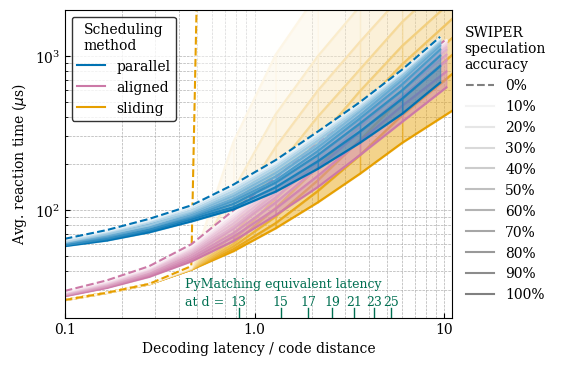

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
colors = ['C0', 'C1', 'C3']
def interpolate(color1, color2, alpha):
    return LinearSegmentedColormap.from_list('_', [color1, color2])(alpha)
def interpolate_white(color, alpha):
    return interpolate('white', color, alpha)
zorders = [2,1.9,1.8]
x_offsets = [-0.5, 0.25, 1.0]
plot_lines = []
legend_lines = []
for i,(scheduling_method,spec_on) in enumerate(ordered_configs):
    data = all_data[(scheduling_method,spec_on)]
    for j,spec_acc in enumerate(sorted(data.keys())):
        keys = sorted(data[spec_acc].keys())
        xvals = keys.copy()
        if len(xvals) == 10:
            xvals[-1] += x_offsets[i]
        if spec_acc == 0:
            alpha = 1
            linestyle = '--'
        else:
            alpha = spec_acc
            linestyle = '-'
        if j+1 < len(data):
            vals_next = data[sorted(data.keys())[j+1]]
            for k,dec_lat in enumerate(sorted(data[spec_acc].keys())):
                if k != len(data[spec_acc])-1:
                    dec_lat_next = sorted(data[spec_acc].keys())[k+1]
                    # if (scheduling_method, spec_on, spec_acc, dec_lat_next) in broken_configs:
                    #     color = 'gray'
                    # else:
                    color = interpolate_white(colors[i], alpha)
                    ax.fill_between(
                        [xvals[k], xvals[k+1]],
                        [data[spec_acc][dec_lat], data[spec_acc][dec_lat_next]],
                        [vals_next[dec_lat], vals_next[dec_lat_next]],
                        color=color,
                        zorder=zorders[i]+0.001*(len(data)-j),
                        alpha=0.5,
                    )
        # alpha = (alpha+1)/2 if spec_acc > 0 else alpha
        lines, = ax.plot(xvals, [data[spec_acc][k] for k in sorted(data[spec_acc].keys())], label=(f'{scheduling_method}' if spec_acc == 1 else None), color=interpolate_white(colors[i], alpha) if spec_acc > 0 else colors[i], linestyle=linestyle, zorder=(zorders[i]+0.01+0.001*(len(data)-j)))
        if spec_acc == 1:
            plot_lines.append(lines)
        if i == 0:
            lines, = ax.plot([-2, -1], [0, 0], label=(f'{spec_acc*100:.0f}%' if spec_acc > 0 else '0%'), color=interpolate_white('gray', alpha) if spec_acc > 0 else 'gray', linestyle=linestyle)
            legend_lines.append(lines)
leg1 = ax.legend(plot_lines, [method for method,_ in ordered_configs], title='Scheduling\nmethod', edgecolor='black')
leg2 = ax.legend(legend_lines, [f'{spec_acc*100:.0f}%' for spec_acc in sorted(data.keys())], title='SWIPER\nspeculation\naccuracy', bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
ax.add_artist(leg1)
plt.xscale('log')
plt.yscale('log')
# plt.xticks(sorted(all_data[('parallel', True)][1.0].keys()),
# sorted(all_data[('parallel', True)][1.0].keys()))
plt.xticks([0.1, 1.0, 10], ['0.1', '1.0', '10'])
plt.tick_params(axis='x', which='minor', bottom=False)
plt.xlabel('Decoding latency / code distance')
plt.ylabel(r'Avg. reaction time ($\mu$s)')
plt.ylim(2e1, 2e3)
plt.xlim(0.1, 11)

textcolor = interpolate('C2', 'black', 0.3)
for dist,r in zip(distances, fit_rs):
    plt.plot([r, r], [plt.ylim()[0], 23], color=textcolor, linestyle='-', linewidth=1)
    plt.text(r, 23, f'{dist}', va='bottom', ha='center', fontsize=9, color=textcolor)
plt.text(0.43, 30, 'PyMatching equivalent latency', va='bottom', ha='left', fontsize=9, color=textcolor)
plt.text(0.43, 23, 'at d =', va='bottom', ha='left', fontsize=9, color=textcolor)

# cmap = mpl.colormaps['Greys']
# cmap = LinearSegmentedColormap.from_list('_', ['white', 'gray'])
# cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.BoundaryNorm(np.linspace(0, 1, 11), cmap.N)), ax=ax, label='Speculation accuracy')
# cbar.ax.invert_yaxis()
plt.tick_params(direction='in', which='both')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('notebooks/figures/sensitivity_study.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/sensitivity_study.svg', bbox_inches='tight')